In [1]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [2]:
# query =\
# '''
# -- query for clustering v2
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT 
#     user_id, 
#     date_,
#     kyc_tier,
#     loyalty_tier,
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , campaigns AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(daily_OTHER_saldo) AS M1_campaign_saldo
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )


# , payments AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     -- TRANSACTIONS
#     COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
#     COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
#     -- CUSTOMER
#     COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
#   FROM `ledger-fcc1e.payment_reports.payments_ssot`
#   WHERE
#     status_v2 = 'COMPLETED'
#     AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# , accountings AS (
#   SELECT DISTINCT
#     DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
#     createdByUser AS user_id,
#     COUNT(DISTINCT transactionId) AS M1_acc_count
#   FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
#   WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# -- //this is a bit inefficient since i load the same table twice...
# -- //open to idea on how to do it better
# -- , banks AS (
# --   SELECT DISTINCT
# --     user_id,
# --     date_,
# --     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
# --   FROM (
# --     SELECT 
# --       user_id,
# --       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
# --       money_in_channel,
# --       COUNT(*) AS cnt_
# --     FROM `ledger-fcc1e.payment_reports.payments_ssot`
# --     WHERE
# --       status_v2 = 'COMPLETED'
# --       AND product_type IN ('SALDO')
# --       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
# --     GROUP BY 1, 2, 3
# --   )
# -- )

# , referrals AS (
#   SELECT 
#     referrer AS user_id,
#     date_,
#     COUNT(DISTINCT referee) AS referee_count
#   FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
#   WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#   GROUP BY 1, 2
# )

# , profiles AS (
#   SELECT DISTINCT
#     user_id,
#     acquisition_channel,
#     user_segment_sub_bucket,
#     first_user_date,
#     first_any_payment_date,
#     first_transaction_date
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-04-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT DISTINCT
#   user_id,
#   date_,
#   kyc_tier,
#   loyalty_tier,
#   (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
#   (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
#   (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
#   M1_campaign_saldo,
#   -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
#   -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
#   -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
#   -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
#   total_customer,
#   -- IFNULL(
#   --   IFNULL(
#   --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
#   --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
#   --   ),
#   --   NULL
#   -- ) AS main_funding_bank,
#   (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
#   acquisition_channel,
#   user_segment_sub_bucket,
#   DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
#   IFNULL(activated_count, 0) AS is_act_m1,
#   IFNULL(converted_count, 0) AS is_conv_m1
# FROM users -- active in last 12 months
# INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
# LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
# -- LEFT JOIN banks USING (user_id, date_)
# LEFT JOIN referrals USING (user_id, date_)
# LEFT JOIN impressions USING (user_id, date_)
# LEFT JOIN accountings USING (user_id, date_)
# LEFT JOIN campaigns USING (user_id, date_)
# LEFT JOIN profiles USING (user_id)
# WHERE date_ < '2023-09-01'
# ORDER BY 1, 2

# '''
# raw = client.query(query).result().to_dataframe()
# raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [3]:
# -- QUERY TO GET IMPRESSIONS COUNT
# imp_query =\
# '''
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT user_id, date_
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_TRUNC(notification_date, MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-05-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT
#   user_id,
#   date_,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
#   IFNULL(activated_count, 0) AS activated_count,
#   IFNULL(converted_count, 0) AS conveted_count
# FROM users
# INNER JOIN loyalty USING (user_id)
# LEFT JOIN impressions USING (user_id, date_)
# WHERE send_count IS NOT NULL
# '''
# imp = client.query(imp_query).result().to_dataframe()
# imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202898 entries, 0 to 202897
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202898 non-null  object
 1   date_                    202898 non-null  dbdate
 2   kyc_tier                 202898 non-null  object
 3   loyalty_tier             202898 non-null  object
 4   M1_core_count            148403 non-null  Int64 
 5   M1_ppob_count            148403 non-null  Int64 
 6   M1_acc_count             201373 non-null  Int64 
 7   M1_campaign_saldo        202743 non-null  Int64 
 8   total_customer           87924 non-null   Int64 
 9   is_referrer              202898 non-null  Int64 
 10  acquisition_channel      202898 non-null  object
 11  user_segment_sub_bucket  202898 non-null  object
 12  age_on_platform_days     202898 non-null  Int64 
 13  is_send_m1               202898 non-null  Int64 
 14  is_imp_m1           

In [5]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        M1_core_count = lambda x: np.log1p(x.M1_core_count),
        M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1', 'M1_campaign_saldo'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days
index_,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0.0,0.693147,1.791759,1,0,Organic Acquisition,pureO2O-PA+PP,5.736572
1161895687 2023-07-01,ADVANCED,Bronze,0.0,1.098612,0.0,2,0,Organic Acquisition,pureO2O-PA+PP,5.828946
1161895687 2023-08-01,ADVANCED,Bronze,0.0,3.135494,3.526361,16,0,Organic Acquisition,pureO2O-PA+PP,5.916202
8111010474 2023-05-01,ADVANCED,Bronze,0.0,0.0,0.693147,<NA>,0,Paid Acquisition,UNKNOWN,5.988961
8111010474 2023-06-01,ADVANCED,Bronze,0.0,0.0,0.0,<NA>,0,Paid Acquisition,UNKNOWN,6.063785
...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0.0,5.365976,0.0,158,0,Offline Acquisition,pureO2O-PAonly,6.426488
8999999557 2023-05-01,SUPREME,Diamond,6.747587,1.386294,0.0,437,0,Offline Acquisition,pureO2O-PAonly,6.152733
8999999557 2023-06-01,SUPREME,Diamond,6.602588,0.0,0.0,318,0,Offline Acquisition,pureO2O-PAonly,6.216606


In [6]:
df.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,age_on_platform_days
count,148403.0,148403.0,201373.0,87924.0,202898.0,202898.0
mean,0.858483,1.215209,1.380325,38.775988,0.052613,5.731648
std,1.558708,1.702547,2.013876,88.935877,0.223259,1.21572
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,2.0,0.0,4.990433
50%,0.0,0.0,0.0,11.0,0.0,6.244167
75%,1.098612,2.397895,2.833213,38.0,0.0,6.60665
max,8.2247,8.548886,9.481817,2907.0,1.0,7.26473


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202898 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   kyc_tier                 202898 non-null  object 
 1   loyalty_tier             202898 non-null  object 
 2   M1_core_count            148403 non-null  Float64
 3   M1_ppob_count            148403 non-null  Float64
 4   M1_acc_count             201373 non-null  Float64
 5   total_customer           87924 non-null   Int64  
 6   is_referrer              202898 non-null  Int64  
 7   acquisition_channel      202898 non-null  object 
 8   user_segment_sub_bucket  202898 non-null  object 
 9   age_on_platform_days     202898 non-null  Float64
dtypes: Float64(4), Int64(2), object(4)
memory usage: 18.2+ MB


In [8]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202898, 10)"
2,Transformed data shape,"(202898, 27)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,6
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [9]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1555,22474.7967,2.1526,0,0,0


In [10]:
# plot_model(kmeans, 'tsne')

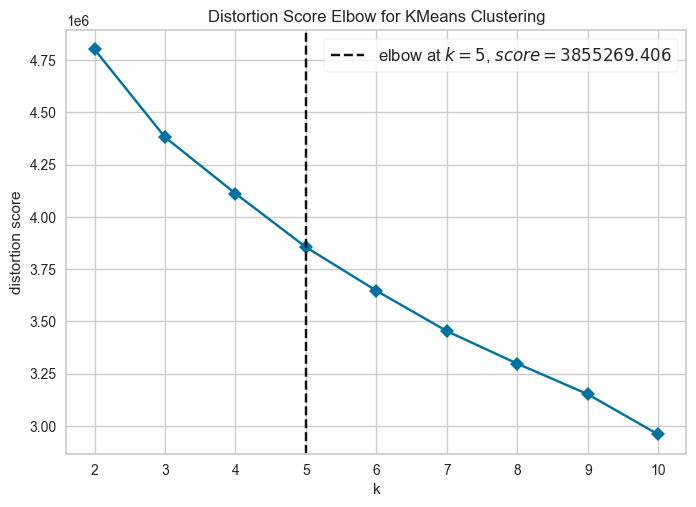

In [11]:
plot_model(kmeans, plot = 'elbow')

In [12]:
# plot_model(kmeans, plot = 'distribution')

In [13]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [14]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84116 entries, 0 to 84115
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84116 non-null  object
 1   date_              84116 non-null  object
 2   send_count         84116 non-null  Int64 
 3   impressions_count  84116 non-null  Int64 
 4   read_count         84116 non-null  Int64 
 5   activated_count    84116 non-null  Int64 
 6   conveted_count     84116 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [15]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.0,0.889878,0.679585,0.411384,0.221313
std,0.0,0.313043,0.466639,0.492088,0.415134
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [16]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [17]:
res.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,total_customer,is_referrer,age_on_platform_days,send_count,impressions_count,read_count,activated_count,conveted_count
count,77672.0,77672.0,83595.0,62494.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.209924,1.836274,0.872669,44.31507,0.064138,5.336305,1.0,0.889878,0.679585,0.411384,0.221313
std,1.76174,1.841651,1.72637,95.818135,0.244999,1.369059,0.0,0.313043,0.466639,0.492088,0.415134
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,3.0,0.0,4.382027,1.0,1.0,0.0,0.0,0.0
50%,0.0,1.386294,0.0,13.0,0.0,5.863631,1.0,1.0,1.0,0.0,0.0
75%,2.302585,3.401197,0.693147,45.0,0.0,6.461468,1.0,1.0,1.0,1.0,0.0
max,8.2247,8.548886,9.481817,2907.0,1.0,7.257708,1.0,1.0,1.0,1.0,1.0


In [18]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       3.367977       2.956548      0.322266   
           Cluster 1        0.90326       1.094463      0.312161   
           Cluster 2       0.041404       1.840199      1.541367   
           Cluster 3       0.078426       1.727712      1.454714   
2023-06-01 Cluster 0       3.134212       3.015972      0.357515   
           Cluster 1       0.727022       0.917679      0.326344   
           Cluster 2       0.042158       2.130978      2.356635   
           Cluster 3       0.112626       1.906229      1.756322   
2023-07-01 Cluster 0       3.190671       2.894994      0.385026   
           Cluster 1        0.56876       0.722715      0.316608   
           Cluster 2       0.067214       2.099273      1.774618   
           Cluster 3       0.193017       1.830712      1.406479   
2023-08-01 Cluster 0       3.028978       2.888064      0.381787   
           Cluster 1       0.930369       1.494813      0.269593   
           Cluster 2       0.029104       2.257295      1.786547   
           Cluster 3       0.083188       2.203798      1.658923   

                      total_customer  is_referrer  age_on_platform_days  \
date_      Cluster                                                        
2023-05-01 Cluster 0      137.850264     0.156142               5.54045   
           Cluster 1       12.037024     0.027728              4.750803   
           Cluster 2       11.592081     0.031764              5.377244   
           Cluster 3       11.547619     0.044618              6.248412   
2023-06-01 Cluster 0      108.089985     0.142928               5.63014   
           Cluster 1       10.269568     0.026823               4.78043   
           Cluster 2       11.532022     0.016748              4.781231   
           Cluster 3       12.058824     0.037803              6.298762   
2023-07-01 Cluster 0       99.539148     0.154575              5.930198   
           Cluster 1        9.975696     0.038647              5.192101   
           Cluster 2        11.27594     0.032967              5.270285   
           Cluster 3       12.161263     0.055177              6.360843   
2023-08-01 Cluster 0      105.584446     0.160344              5.990866   
           Cluster 1       12.458855     0.041986              5.044694   
           Cluster 2       12.275585      0.03303              5.328617   
           Cluster 3       15.167521     0.061763              6.436271   

                      send_count  impressions_count  read_count  \
date_      Cluster                                                
2023-05-01 Cluster 0         1.0           0.905968    0.773768   
           Cluster 1         1.0           0.890882    0.722858   
           Cluster 2         1.0           0.897852    0.719607   
           Cluster 3         1.0           0.910764    0.707195   
2023-06-01 Cluster 0         1.0           0.900272    0.737596   
           Cluster 1         1.0           0.874985    0.648942   
           Cluster 2         1.0           0.916153     0.66537   
           Cluster 3         1.0           0.914353    0.648553   
2023-07-01 Cluster 0         1.0            0.89319     0.71912   
           Cluster 1         1.0           0.866945    0.600273   
           Cluster 2         1.0           0.897506    0.688926   
           Cluster 3         1.0            0.89782    0.636921   
2023-08-01 Cluster 0         1.0           0.885282    0.715682   
           Cluster 1         1.0           0.870418    0.668159   
           Cluster 2         1.0           0.891806    0.671607   
           Cluster 3         1.0            0.89313    0.634282   

                      activated_count  conveted_count  
date_      Cluster                                     
2023-05-01 Cluster 0         0.816447         0.72762  
           Cluster 1         0.383915        0.189543  
           Clus

In [19]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0      2882          2882           2882           2882   
           Cluster 1      7249          7249           7162           7162   
           Cluster 2      4376          4376           4188           4188   
           Cluster 3      1793          1793           1775           1775   
2023-06-01 Cluster 0      4051          4051           4051           4051   
           Cluster 1      8463          8463           8380           8380   
           Cluster 2      9255          9255           4039           4039   
           Cluster 3      1693          1693           1308           1308   
2023-07-01 Cluster 0      7181          7181           7181           7181   
           Cluster 1     12446         12446          12396          12396   
           Cluster 2      4732          4732           4525           4525   
           Cluster 3      1468          1468           1454           1454   
2023-08-01 Cluster 0      7671          7671           7671           7671   
           Cluster 1      4692          4692           4674           4674   
           Cluster 2      4723          4723           4566           4566   
           Cluster 3      1441          1441           1420           1420   

                      M1_acc_count  total_customer  is_referrer  \
date_      Cluster                                                
2023-05-01 Cluster 0          2882            2845         2882   
           Cluster 1          7188            5618         7249   
           Cluster 2          4309            3258         4376   
           Cluster 3          1791            1344         1793   
2023-06-01 Cluster 0          4051            3934         4051   
           Cluster 1          8416            5468         8463   
           Cluster 2          9088            3560         9255   
           Cluster 3          1689            1054         1693   
2023-07-01 Cluster 0          7181            7063         7181   
           Cluster 1         12413            6501        12446   
           Cluster 2          4666            3990         4732   
           Cluster 3          1464            1172         1468   
2023-08-01 Cluster 0          7671            7342         7671   
           Cluster 1          4678            4071         4692   
           Cluster 2          4668            4104         4723   
           Cluster 3          1440            1170         1441   

                      acquisition_channel  user_segment_sub_bucket  \
date_      Cluster                                                   
2023-05-01 Cluster 0                 2882                     2882   
           Cluster 1                 7249                     7249   
           Cluster 2                 4376                     4376   
           Cluster 3                 1793                     1793   
2023-06-01 Cluster 0                 4051                     4051   
           Cluster 1                 8463                     8463   
           Cluster 2                 9255                     9255   
           Cluster 3                 1693                     1693   
2023-07-01 Cluster 0                 7181                     7181   
           Cluster 1                12446                    12446   
           Cluster 2                 4732                     4732   
           Cluster 3                 1468                     1468   
2023-08-01 Cluster 0                 7671                     7671   
           Cluster 1                 4692                     4692   
           Cluster 2                 4723                     4723   
           Cluster 3                 1441                     1441   

                      age_on_platform_days  user_id  send_count  \
date_      Cluster                                                
2023-05-01 Clus